In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization] pandas scikit-learn numpy

# MPG Simple Target [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/hamilton-tutorials/mpg-translation/MPGSimpleTarget.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/hamilton-tutorials/mpg-translation/MPGSimpleTarget.ipynb)


In [2]:
from hamilton import driver
from IPython.display import HTML, display

/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
%load_ext hamilton.plugins.jupyter_magic

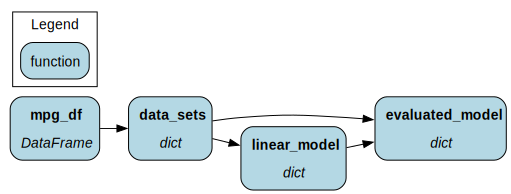

In [4]:
%%cell_to_module pipeline --display
# when done you can write to file and then load it as a module normally
# add -w to do so
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error


def mpg_df() -> pd.DataFrame:
    url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
    column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                    'Acceleration', 'Model Year', 'Origin']

    raw_dataset = pd.read_csv(url, names=column_names,
                            na_values='?', comment='\t',
                            sep=' ', skipinitialspace=True)

    ## some schema manipulation
    _mpg_df = raw_dataset.rename(columns={"Model Year": "ModelYear"})
    return _mpg_df

def data_sets(mpg_df: pd.DataFrame) -> dict:
    # Do some feature engineering / data cleaning to create the data sets
    # one hot encode -- we know the encoding here.
    for value, country in {1: "USA", 2: "Europe", 3: "Japan"}.items():
        mpg_df[country] = np.where(mpg_df["Origin"] == value, 1, 0)
    raw_dataset = mpg_df.dropna()
    # create data sets
    train_test_split = 0.8
    seed = 123
    # split the pandas dataframe into train and test
    train_dataset = raw_dataset.sample(frac=train_test_split, random_state=seed)
    test_dataset = raw_dataset.drop(train_dataset.index)

    return {"train": train_dataset, "test": test_dataset}


def linear_model(data_sets: dict) -> dict:
    train_dataset = data_sets["train"]
    # Fit the model
    ## config for fitting a model
    target_column: str = "MPG"

    ## fit a model
    # pull out target
    train_labels = train_dataset.pop(target_column)
    # Convert boolean columns to integers for the model
    bool_columns = train_dataset.select_dtypes(include=[bool]).columns
    train_dataset[bool_columns] = train_dataset[bool_columns].astype(int)
    # Normalize the features for the model
    scaler = StandardScaler()
    train_dataset_scaled = scaler.fit_transform(train_dataset)
    
    # Initialize and fit the Linear Regression model
    linear_model = LinearRegression()
    linear_model.fit(train_dataset_scaled, train_labels)
    return {"linear_model": linear_model, "scaler": scaler}

def evaluated_model(linear_model: dict, data_sets: dict) -> dict:
    test_dataset = data_sets["test"]
    target_column: str = "MPG"
    # evaluate the model - pull out target
    test_labels = test_dataset.pop(target_column)
    # Evaluate the model
        # convert boolean columns to integers for the model
    bool_columns = test_dataset.select_dtypes(include=[bool]).columns
    test_dataset[bool_columns] = test_dataset[bool_columns].astype(int)
    test_dataset_scaled = linear_model["scaler"].transform(test_dataset)
    
    # Predict and evaluate the model
    test_pred = linear_model["linear_model"].predict(test_dataset_scaled)
    mae = mean_absolute_error(test_labels, test_pred)
    test_results = {
        "linear_model": mae
    }
    return test_results


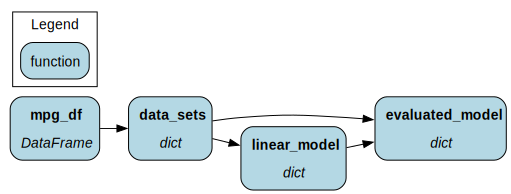

In [5]:
dr = driver.Builder().with_modules(pipeline).build()
dr

In [6]:
result = dr.execute(["evaluated_model", "linear_model"])
result

{'evaluated_model': {'linear_model': 2.4926580150007007},
 'linear_model': {'linear_model': LinearRegression(),
  'scaler': StandardScaler()}}

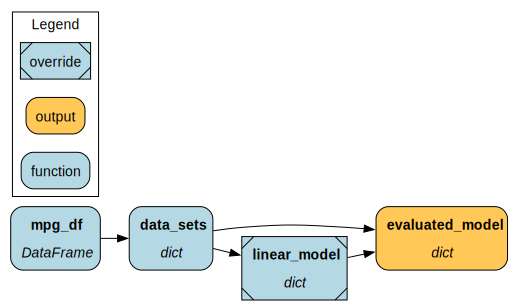

In [7]:
# Visualize Overrides
dr.visualize_execution(["evaluated_model"], 
                       overrides={"linear_model": result["linear_model"]})

In [8]:
# Execute with overrides
dr.execute(["evaluated_model"], overrides={"linear_model": result["linear_model"]})

{'evaluated_model': {'linear_model': 2.4926580150007007}}